In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
from google.colab import files
#Loading the dataset
uploaded = files.upload()

Saving Energy_consumption.csv to Energy_consumption (1).csv


In [ ]:
#Reading the dataset
df = pd.read_csv("Energy_consumption.csv")
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


# Feature Engineering

In [ ]:
#Converting timestamp to datetime datatype
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')


In [ ]:
#Creating time features
df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
df['dayofweek'] = df['Timestamp'].dt.dayofweek


Helps models to better understand time based features

In [ ]:
#Binning the Hours into 4 categories

def hour_bin(h):
    if 0 <= h < 6:
        return 'night'
    elif 6 <= h < 12:
        return 'morning'
    elif 12 <= h < 18:
        return 'afternoon'
    else:
        return 'evening'

df['hour_bin'] = df['hour'].apply(hour_bin)

Hour Binning is used for pattern capturing

In [ ]:
#Cyclical Encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


In [ ]:
df['Temp_Occupancy'] = df['Temperature'] * df['Occupancy']

#Lag Features for HVAC, Lighting anf Occupancy

df['HVAC_lag_1'] = df['HVACUsage'].shift(1)
df['Lighting_lag_1'] = df['LightingUsage'].shift(1)
df['Occupancy_lag_1'] = df['Occupancy'].shift(1)

#Rolling Mean For Temperature and Humidity
df['Temp_roll_24'] = df['Temperature'].rolling(24).mean()
df['Humidity_roll_24'] = df['Humidity'].rolling(24).mean()

In [ ]:
#lag for energy consumption
for lag in [1, 3, 24]:
    df[f'energy_lag_{lag}'] = df['EnergyConsumption'].shift(lag)

In [ ]:
for window in [6, 24]:
    df[f'energy_roll_mean_{window}'] = (
        df['EnergyConsumption'].shift(1).rolling(window).mean()
    )
    df[f'energy_roll_std_{window}'] = (
        df['EnergyConsumption'].shift(1).rolling(window).std()
    )

In [ ]:
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})

#One-hot encoding for DAYS
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)

In [ ]:
df = df.drop(columns=['day', 'month'])
df = df.drop(columns=['hour'])
df = df.drop(columns=['dayofweek'])

In [ ]:
df = pd.get_dummies(
    df,
    columns=['HVACUsage','HVAC_lag_1', 'Lighting_lag_1', 'LightingUsage', 'Holiday', 'hour_bin'],
    drop_first=True
)
df.head()


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,hour_sin,hour_cos,Temp_Occupancy,...,DayOfWeek_Tuesday,DayOfWeek_Wednesday,HVACUsage_1,HVAC_lag_1_On,Lighting_lag_1_On,LightingUsage_1,Holiday_1,hour_bin_evening,hour_bin_morning,hour_bin_night
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,2.774699,75.364373,0.000000,1.000000,125.697167,...,False,False,True,False,False,False,False,False,False,True
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,21.831384,83.401855,0.258819,0.965926,27.731651,...,False,False,True,True,False,True,False,False,False,True
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,6.764672,78.270888,0.500000,0.866025,57.408554,...,False,False,False,True,True,False,False,False,False,True
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,8.623447,56.519850,0.707107,0.707107,20.080469,...,False,True,False,False,False,True,False,False,False,True
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,3.071969,70.811732,0.866025,0.500000,207.876233,...,False,False,True,False,True,False,False,False,False,True


In [ ]:
df = df.drop(columns=['Timestamp'])
df = df.dropna()


#Model Training

In [ ]:
split = int(len(df) * 0.8)
train = df.iloc[:split]
test = df.iloc[split:]

X_train = train.drop('EnergyConsumption', axis=1)
y_train = train['EnergyConsumption']
X_test = test.drop('EnergyConsumption', axis=1)
y_test = test['EnergyConsumption']

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_test_pred = ridge.predict(X_test_scaled)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"R-squared (R2) Score: {r2_score(y_test, y_test_pred):.2f}")

Mean Absolute Error (MAE): 4.29
R-squared (R2) Score: 0.56


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"R-squared (R2) Score: {r2_score(y_test, y_test_pred):.2f}")

Mean Absolute Error (MAE): 4.20
R-squared (R2) Score: 0.57


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    objective='reg:squarederror',
    random_state=42
)

xgb.fit(X_train, y_train)
y_test_pred = xgb.predict(X_test)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"R-squared (R2) Score: {r2_score(y_test, y_test_pred):.2f}")

Mean Absolute Error (MAE): 4.35
R-squared (R2) Score: 0.55


In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm.fit(X_train, y_train)
y_test_pred = lgbm.predict(X_test)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"R-squared (R2) Score: {r2_score(y_test, y_test_pred):.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 32
[LightGBM] [Info] Start training from score 76.918236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

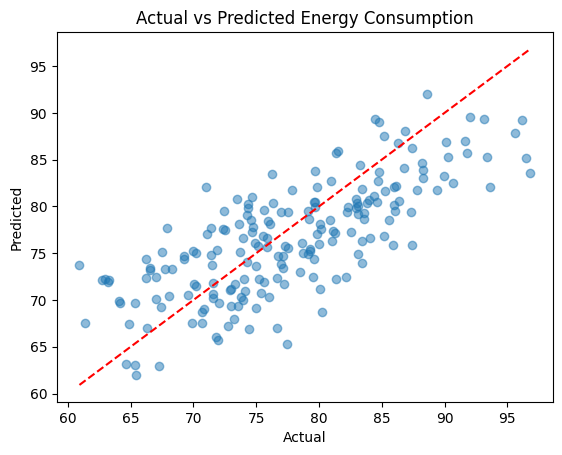

In [ ]:
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()


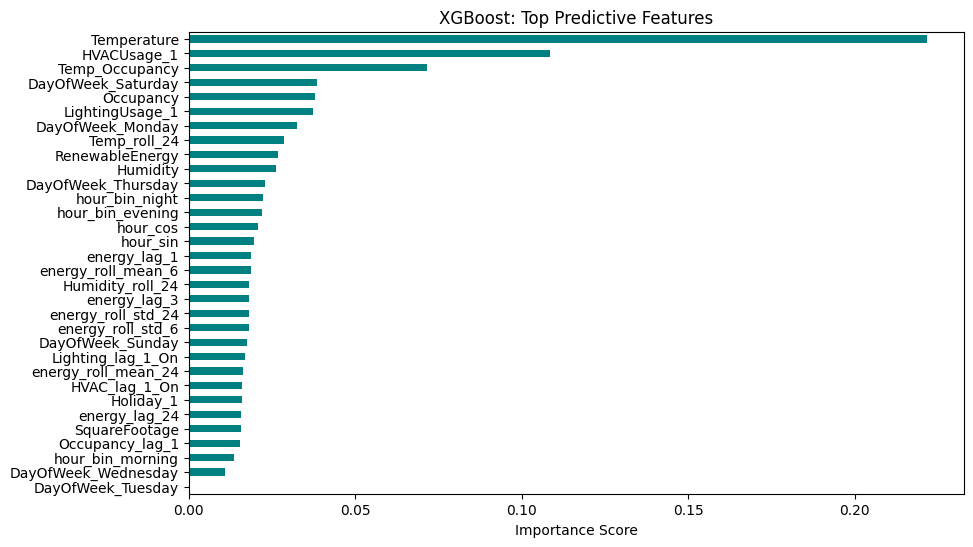

In [ ]:
importances = xgb.feature_importances_
feature_names = X_train.columns

feat_import = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_import.plot(kind='barh', color='teal')
plt.title("XGBoost: Top Predictive Features")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
import joblib

joblib.dump(
    {
        "model": xgb,
        "feature_names": X_train.columns.tolist()
    },
    "xgb_energy_model.pkl"
)


['xgb_energy_model.pkl']

In [ ]:
bundle = joblib.load("xgb_energy_model.pkl")

xgb_loaded = bundle["model"]
feature_names = bundle["feature_names"]


In [ ]:
print(feature_names)
print(len(feature_names))

['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'hour_sin', 'hour_cos', 'Temp_Occupancy', 'Occupancy_lag_1', 'Temp_roll_24', 'Humidity_roll_24', 'energy_lag_1', 'energy_lag_3', 'energy_lag_24', 'energy_roll_mean_6', 'energy_roll_std_6', 'energy_roll_mean_24', 'energy_roll_std_24', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'HVACUsage_1', 'HVAC_lag_1_On', 'Lighting_lag_1_On', 'LightingUsage_1', 'Holiday_1', 'hour_bin_evening', 'hour_bin_morning', 'hour_bin_night']
32


In [ ]:
sample_peak = {
    # Basic Features
    'Temperature': 27.73,
    'Humidity': 54.2,
    'SquareFootage': 1411.069,
    'Occupancy': 1,
    'RenewableEnergy': 21.87,

    # Time Features
    'hour_sin': -0.5,           # for 2 PM
    'hour_cos': -0.866,
    'Temp_Occupancy': 27.73 * 1, # Interaction

    # New Lagged States (Added)
    'Occupancy_lag_1': 1,       # Occupancy 1 hour ago
    'Temp_roll_24': 26.5,       # Avg Temp over last 24h
    'Humidity_roll_24': 50.0,   # Avg Humidity over last 24h

    # Energy History
    'energy_lag_1': 72.5,
    'energy_lag_3': 68.0,
    'energy_lag_24': 70.0,
    'energy_roll_mean_6': 65.0,
    'energy_roll_std_6': 4.2,
    'energy_roll_mean_24': 55.0,
    'energy_roll_std_24': 12.5,

    # Calendar Features
    'DayOfWeek_Monday': 0,
    'DayOfWeek_Saturday': 1,
    'DayOfWeek_Sunday': 0,
    'DayOfWeek_Thursday': 0,
    'DayOfWeek_Tuesday': 0,
    'DayOfWeek_Wednesday': 0,

    # Binary Usage & Lags (Added)
    'HVACUsage_1': 1,       # Current HVAC Status
    'HVAC_lag_1_On': 1,
    'Lighting_lag_1_On': 1,
    'LightingUsage_1': 1,   # Current Lighting Status
    'Holiday_1': 0,

    # Hour Bins
    'hour_bin_evening': 0,
    'hour_bin_morning': 0,
    'hour_bin_night': 0     # Afternoon
}

In [ ]:
test_df = pd.DataFrame([sample_peak])

cols_order = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy',
              'hour_sin', 'hour_cos', 'Temp_Occupancy','Occupancy_lag_1','Temp_roll_24','Humidity_roll_24','energy_lag_1', 'energy_lag_3',
              'energy_lag_24', 'energy_roll_mean_6', 'energy_roll_std_6', 'energy_roll_mean_24',
              'energy_roll_std_24', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
              'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'HVACUsage_1', 'HVAC_lag_1_On','Lighting_lag_1_On',
              'LightingUsage_1', 'Holiday_1', 'hour_bin_evening', 'hour_bin_morning', 'hour_bin_night']

test_df = test_df[cols_order]

# 4. Predict
prediction = xgb_loaded.predict(test_df)
print(f"Predicted Energy Consumption: {prediction[0]:.2f} kWh")

Predicted Energy Consumption: 83.57 kWh
